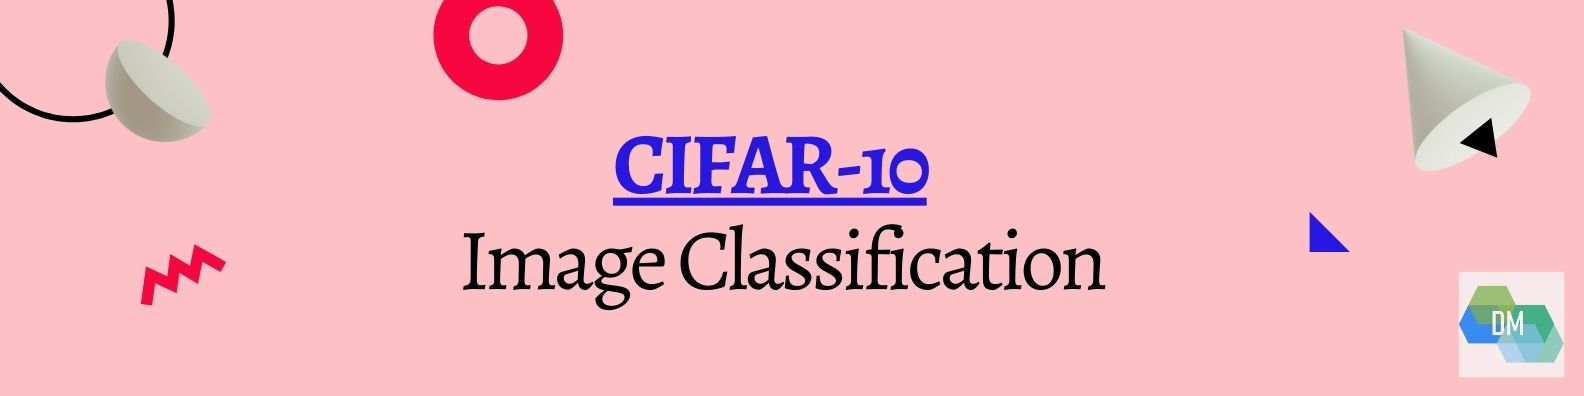

<blockquote>📌 In CIFAR-10, there are 60000, 32x32 color images from these 10 classes, with 6000 images from each class. The training dataset contains 50,000 training images and the test dataset contains 10000 test images.
<br><br>
The dataset images are of color images with a (32 x 32) resolution. All the images in the dataset are of shape (32,32,3) where 3 represents the number of channels i.e R-G-B (Red,Green & Blue).
</blockquote>

### <h3 style="background-color:#f78e77;color:white;text-align: center;padding-top: 5px;padding-bottom: 5px;border-radius: 15px 50px;"><strong><centre>Importing Libraries & Packages 📚 </centre></strong></h3>

pip install visualkeras

In [ ]:
# getting started with the model 
# importing required libraries/packages 

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout
from tensorflow.keras.layers import GlobalMaxPooling2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score

import visualkeras
from PIL import ImageFont
#font = ImageFont.truetype("arial.ttf", 12)

import warnings 
warnings.filterwarnings('ignore')

print("Tensorflow version:",tf.__version__)
print("Keras version:",keras.__version__)

### <h3 style="background-color:#f78e77;color:white;text-align: center;padding-top: 5px;padding-bottom: 5px;border-radius: 15px 50px;"><strong><centre>✏️ Importing & Reading the dataset 📝 </centre></strong></h3>

<blockquote>📌 The Keras dataset module already comes with the CIFAR-10 dataset. So,we can directly import it using the ‘keras.datasets’ command.</blockquote>

In [ ]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [ ]:
# Importing the CIFAR-10 dataset from Keras 
from tensorflow.keras.datasets import cifar10
(X_train, Y_train), (X_test, Y_test) = cifar10.load_data()

In [ ]:
print('X_train Shape: {}'.format(X_train.shape))
print('X_test Shape: {}'.format(X_test.shape))
print('Y_train Shape: {}'.format(Y_train.shape))
print('Y_test Shape: {}'.format(Y_test.shape))

In [ ]:
plt.figure()
plt.imshow(X_train[12])
plt.colorbar()

### <h3 style="background-color:#f78e77;color:white;text-align: center;padding-top: 5px;padding-bottom: 5px;border-radius: 15px 50px;"><strong><centre>Normalizing and One-Hot Encoding 🗝</centre></strong></h3>

<blockquote>📌 We have to normalize the data in order to reduce the pixel values. Currently, all the image pixels are in a range from 0–255, and we want the values in the range of 0 and 1. So we can either divide all the pixel values by 255.0 or use the ‘normalize’ command from keras library. As CIFAR-10 has 10 classes, we are using the ‘to_categorical()’ method to one-hot encode the data.</blockquote>

In [ ]:
# Normalizing
X_train = X_train/255
X_test = X_test/255

# One-Hot-Encoding
Y_train_en = to_categorical(Y_train,10)
Y_test_en = to_categorical(Y_test,10)

In [ ]:
# Visualizing the data 
for i in range(1,31):
  plt.subplot(2, 15, i)
  plt.imshow(X_train[i])

### <h3 style="background-color:#f78e77;color:white;text-align: center;padding-top: 5px;padding-bottom: 5px;border-radius: 15px 50px;"><strong><centre>🔨 Building Base Model 🔧</centre></strong></h3>

<blockquote>📌 Now it’s time to build our model. We are going to use a Convolution Neural Network (CNN) to train our model.</blockquote>

In [ ]:
# detect and init the TPU
tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()

# instantiate a distribution strategy
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

In [ ]:
with tpu_strategy.scope():
    # Base Model
    model = Sequential()
    model.add(Conv2D(32,(4,4),input_shape = (32,32,3),activation='relu'))
    model.add(MaxPooling2D(pool_size = (2,2)))
    model.add(Conv2D(32,(4,4),input_shape = (32,32,3),activation='relu'))
    model.add(MaxPooling2D(pool_size = (2,2)))
    model.add(Flatten())
    model.add(Dense(128, activation ='relu'))
    model.add(Dense(10, activation ='softmax'))
    model.compile(loss ='categorical_crossentropy', optimizer ='adam', metrics =['accuracy'])

In [ ]:
model.summary()
history = model.fit(X_train, Y_train_en, epochs = 30, verbose=1,validation_data=(X_test,Y_test_en))

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='cnn_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
visualkeras.layered_view(model, legend=True)

In [ ]:
evaluation = model.evaluate(X_test, Y_test_en)
print('Test Accuracy of Base Model: {}'.format(evaluation[1]))

In [ ]:
def plotloss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.plot(history.history['accuracy'])
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation', 'Accuracy'])
    plt.show()    
plotloss(history)

<blockquote>📌 After running our base model with 30 Epochs, we are getting 94.05% training accuracy and 64.86% test accuracy which is good but as we can see the validation loss is continuously increasing from the first epoch till the last epoch i.e our base model is overfitting. 
<br><br>
We can achieve this by adding a few dropout layers in our model. Now we are building our model by dropping 25% of units.</blockquote>

### <h3 style="background-color:#f78e77;color:white;text-align: center;padding-top: 5px;padding-bottom: 5px;border-radius: 15px 50px;"><strong><centre>Model-1 with Dropouts 🛠</centre></strong></h3>

In [ ]:
# Model_1 with Dropouts
model_1 = Sequential()
model_1.add(Conv2D(64,(4,4),input_shape=(32,32,3),activation='relu'))
model_1.add(MaxPooling2D(pool_size=(2,2)))
model_1.add(Dropout(0.5)) 
model_1.add(Conv2D(64,(4,4),input_shape=(32,32,3),activation='relu'))
model_1.add(MaxPooling2D(pool_size=(2,2)))
model_1.add(Dropout(0.25))
model_1.add(Flatten())
model_1.add(Dense(256,activation='relu'))
model_1.add(Dense(10,activation='softmax'))
model_1.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
model_1.summary()
history_1 = model_1.fit(X_train, Y_train_en, epochs = 50, verbose=1, validation_data=(X_test,Y_test_en))

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model_1, to_file='cnn_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
visualkeras.layered_view(model_1, legend=True)

In [ ]:
evaluation = model_1.evaluate(X_test, Y_test_en)
print('Test Accuracy of Model_1(with Dropouts): {}'.format(evaluation[1]))

In [ ]:
def plotloss(history_1):
    plt.plot(history_1.history['loss'])
    plt.plot(history_1.history['val_loss'])
    plt.plot(history_1.history['accuracy'])
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation', 'Accuracy'])
    plt.show()    
plotloss(history_1)

<blockquote>📌 After running our model_1 with 50 Epochs, we can see that the validation accuracy has improved from 64.86% to 71.96% due to reduction in our model’s validation loss from 2.1182 to 1.0532. 
<br><br>    
We will continue to train our model by increasing the number of epochs and by adding more filters.</blockquote>

### <h3 style="background-color:#f78e77;color:white;text-align: center;padding-top: 5px;padding-bottom: 5px;border-radius: 15px 50px;"><strong><centre>Model-2 with more filters 🛠</centre></strong></h3>

In [ ]:
# Model_2 with more filters
model_2 = Sequential()
model_2.add(Conv2D(64,(4,4),input_shape=(32,32,3),activation='relu'))
model_2.add(Conv2D(64,(4,4),input_shape=(32,32,3),activation='relu'))
model_2.add(MaxPooling2D(pool_size=(2,2)))
model_2.add(Dropout(0.4)) 
model_2.add(Conv2D(128,(4,4),input_shape=(32,32,3),activation='relu'))
model_2.add(Conv2D(128,(4,4),input_shape=(32,32,3),activation='relu'))
model_2.add(MaxPooling2D(pool_size=(2,2)))
model_2.add(Dropout(0.4))
model_2.add(Flatten())
model_2.add(Dense(1024,activation='relu'))
model_2.add(Dense(1024,activation='relu'))
model_2.add(Dense(units =10  , activation = 'softmax'))
model_2.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
model_2.summary()
history_2 = model_2.fit(X_train, Y_train_en, epochs = 100, verbose=1, validation_data=(X_test,Y_test_en))

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model_2, to_file='cnn_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
visualkeras.layered_view(model_2, legend=True)

In [ ]:
evaluation = model_2.evaluate(X_test, Y_test_en)
print('Test Accuracy of Model_2(with more  filters): {}'.format(evaluation[1]))

In [ ]:
def plotloss(history_2):
    plt.plot(history_2.history['loss'])
    plt.plot(history_2.history['val_loss'])
    plt.plot(history_2.history['accuracy'])
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation', 'Accuracy'])
    plt.show()    
plotloss(history_2)

<blockquote>📌 After running our model_2 with 100 Epochs, we can see that the validation accuracy has further improved from 71.96% to 75.79%
<br><br>
We will continue to train our model by adding Batch Normalization.
</blockquote>

### <h3 style="background-color:#f78e77;color:white;text-align: center;padding-top: 5px;padding-bottom: 5px;border-radius: 15px 50px;"><strong><centre>Model-3 with Batch Normalization 🛠</centre></strong></h3>

In [ ]:
# Model_3 with Batch Normalization
model_3 = Sequential()
model_3.add(Conv2D(64,(4,4),input_shape=(32,32,3),activation='relu',padding='same'))
model_3.add(BatchNormalization())
model_3.add(Conv2D(64,(4,4),input_shape=(32,32,3),activation='relu',padding='same'))
model_3.add(BatchNormalization())
model_3.add(MaxPooling2D(pool_size=(2,2)))
model_3.add(Dropout(0.2))
model_3.add(Conv2D(128,(4,4),input_shape=(32,32,3),activation='relu',padding='same'))
model_3.add(BatchNormalization())
model_3.add(Conv2D(128,(4,4),input_shape=(32,32,3),activation='relu',padding='same'))
model_3.add(BatchNormalization())
model_3.add(MaxPooling2D(pool_size=(2,2)))
model_3.add(Dropout(0.25))
model_3.add(Conv2D(128,(4,4),input_shape=(32,32,3),activation='relu',padding='same'))
model_3.add(BatchNormalization())
model_3.add(Conv2D(128,(4,4),input_shape=(32,32,3),activation='relu',padding='same'))
model_3.add(BatchNormalization())
model_3.add(MaxPooling2D(pool_size=(2,2)))
model_3.add(Dropout(0.35))
model_3.add(Flatten())
model_3.add(Dense(256, activation='relu'))
model_3.add(BatchNormalization())
model_3.add(Dropout(0.5))
model_3.add(Dense(10, activation='softmax'))
model_3.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
model_3.summary()
history_3 = model_3.fit(X_train, Y_train_en, epochs = 100, verbose = 1, validation_data = (X_test, Y_test_en))

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model_3, to_file='cnn_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
visualkeras.layered_view(model_3, legend=True)

In [ ]:
evaluation = model_3.evaluate(X_test, Y_test_en)
print('Test Accuracy of Model_3 (with Batch Normalization): {}'.format(evaluation[1]))

In [ ]:
def plotloss(history_3):
    plt.plot(history_3.history['loss'])
    plt.plot(history_3.history['val_loss'])
    plt.plot(history_3.history['accuracy'])
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation', 'Accuracy'])
    plt.show()    
plotloss(history_3)

<blockquote>📌 After running our model_3 with Batch Normalization, we can see that the validation accuracy has further improved from 75.79% to 87.68%
</blockquote>

📌 Details of the model setup and the results are discussed in my article https://devashree-madhugiri.medium.com/using-cnn-for-image-classification-on-cifar-10-dataset-7803d9f3b983 published on Medium.